In [ ]:
from Imports import *
from Plotting import *
from Helper import *
from Preprocessing import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
jet_images_path = '../data/jet-images_Mass60-100_pT250-300_R1.25_Pix25.hdf5'
jet_mass_data = HDF5File(jet_images_path, 'r')

print(jet_mass_data.keys())
print(jet_mass_data['image'].shape)

<KeysViewHDF5 ['image', 'jet_delta_R', 'jet_eta', 'jet_mass', 'jet_phi', 'jet_pt', 'signal', 'tau_1', 'tau_2', 'tau_21', 'tau_3', 'tau_32']>
(872666, 25, 25)


In [6]:
dev = qml.device("default.qubit", wires=8)
n_layers = 1

# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 3))

@qml.qnode(dev)
def quantum_feature_embedding(f, phi, interface="torch", diff_method="backprop", cachesize=1000000):
    qml.AmplitudeEmbedding(features=f, wires=range(8), normalize=True, pad_with=0.)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(8)))

    # Measurement producing classical output values
    return qml.state()
    # return [qml.expval(qml.PauliZ(j)) for j in range(4)]

state = quantum_feature_embedding(f=[1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4], phi=rand_params)
print(state.shape)

def quantum_feature_embedding_batch(x_batch, phi, device="cuda"):
    """
    Applies quantum_feature_embedding_single to a batch of inputs.

    Args:
        x_batch (torch.Tensor): (B, D) input batch.
        phi (np.ndarray or torch.Tensor): parameters for RandomLayers.
        device (str): Device to return output on.

    Returns:
        torch.Tensor: Output of shape (B, 2 ** n_qubits)
    """
    outputs = []
    for x in x_batch:
        result = quantum_feature_embedding(x, phi)
        result_tensor = result.real.to(device)
        outputs.append(result_tensor)

    return torch.stack(outputs)

sample = torch.randn(16, 9).to("cuda")  # Example batch
phi_tensor = torch.tensor(rand_params, dtype=torch.float32)

output = quantum_feature_embedding_batch(sample, phi_tensor)
print(output.shape)

class quantum_feature_embedding_batch(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.phi = nn.Parameter(torch.tensor(np.random.uniform(high=2 * np.pi, size=(n_layers, 3)), dtype=torch.float32))
    
    def forward(self, x_batch):
        phi = self.phi
        outputs = []
        for x in x_batch:
            result = quantum_feature_embedding(x, phi)
            result_tensor = result.real.to(device)
            outputs.append(result_tensor)
    
        return torch.stack(outputs)

(256,)


/home/users.cms.physics.ua.edu/webbj/miniconda3/envs/myenv/lib/python3.10/site-packages/pennylane/math/interface_utils.py:136: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


torch.Size([16, 256])


In [7]:
# Generator with Quantum Layer
class Generator(nn.Module):
    def __init__(self, latent_dim=9):
        super().__init__()

        self.noise = GaussianNoise(sigma=0.2)
        
        self.feature_gen = quantum_feature_embedding_batch()

        self.image_gen1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 1x1 → 2x2
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 2x2 → 4x4
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )
        self.image_gen3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 4x4 → 8x8
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Dropout(0.2),
        )

        self.image_gen4 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 8x8 → 16x16
            nn.Sigmoid()
        )

    def forward(self, z_feat):
        img = self.feature_gen(z_feat).float()
        # print(img.shape)
        img = img.view(-1, 256, 1, 1)
        # print(img.shape)
        img = self.image_gen1(img)
        # print(img.shape)
        img = self.image_gen2(img)
        # print(img.shape)
        img = self.image_gen3(img)
        # print(img.shape)
        img = self.image_gen4(img)
        # print(img.shape)
        img = soft_threshold(img, threshold=0.001, sharpness=1000.0)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
                # Flattened image: 16x16 = 256
        self.image_encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(1, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2),
            nn.Flatten()
        )

        self.feature_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
        )

        # Dynamically get input dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 16, 16)
            flat_dim = self.image_encoder(dummy).shape[1] + 64

        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(flat_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
   
    def forward(self, img, features):
        img_encoded = self.image_encoder(img)
        feat_encoded = self.feature_encoder(features)
        combined = torch.cat((img_encoded, feat_encoded), dim=1)

        # print(img_encoded.shape)
        # print(feat_encoded.shape)
        # print(combined.shape[-1])

        prob = self.classifier(combined)

        return prob  # Shape: (batch_size, 1)

Image shape: torch.Size([87266, 16, 16])
dR Mean: torch.Size([87266])
dR STD: torch.Size([87266])
Pixel Mean: torch.Size([87266])
Pixel STD: torch.Size([87266])
ΔR min: 0.0
ΔR max: 2.203810453414917
ΔR mean min: 0.003941118251532316
ΔR mean max: 0.0156550332903862
ΔR std min: 0.020212490111589432
ΔR std max: 0.14540068805217743
Weights (pixel intensity) min: 0.0
Weights (pixel intensity) max: 1.0
Pixel mean min: 0.0028264394495636225
Pixel mean max: 0.00432002916932106
Pixel std min: 0.009188652969896793
Pixel std max: 0.06249340996146202


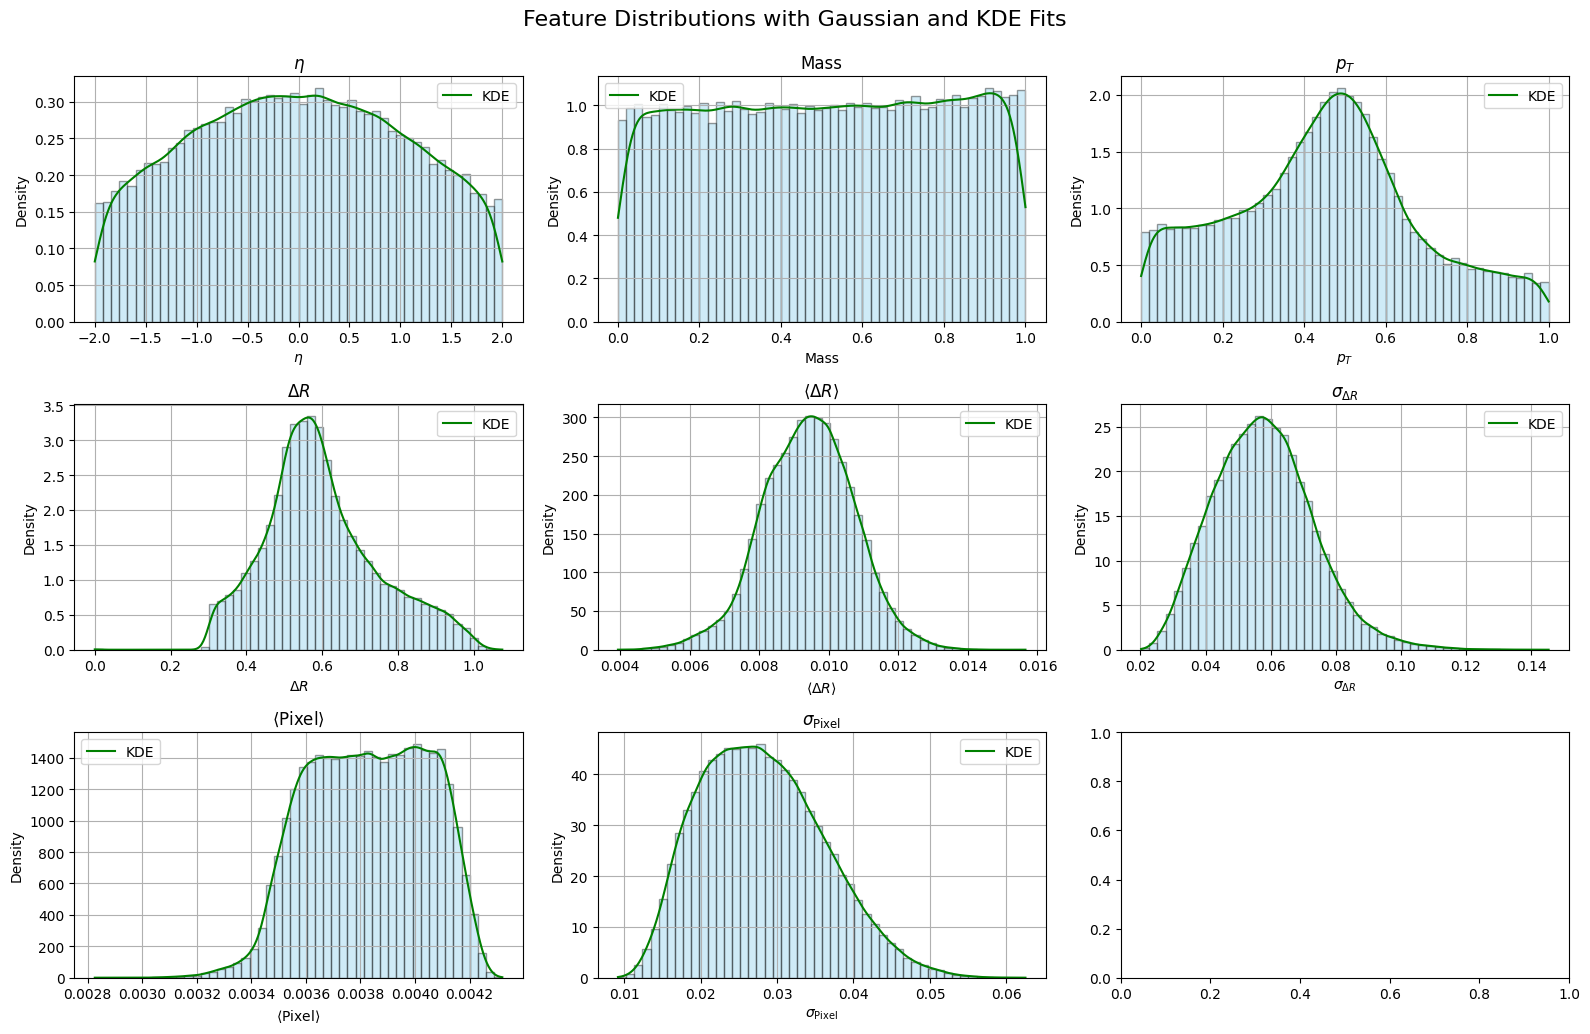

Number of samples: 87266
Image shape: torch.Size([87266, 16, 16])
Feature shape: torch.Size([87266, 9])


In [8]:
batch_size = 128*3
n_events = int(.1 * jet_mass_data['image'].shape[0])

dataset = JetDataset(jet_mass_data, n_events)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

kdes = feature_distributions(dataset)

print("Number of samples:", len(dataset))
print("Image shape:", dataset.images.shape)
print("Feature shape:", dataset.features.shape)

[Epoch 1/300] [D loss: 1.0710] [G loss: 0.1918] [Validity_loss: 0.1742] 
 [Stat_loss: 0.0018] [NNZ_loss: 0.0158]
Sample feature coding: [1.         1.7490841  0.3829829  0.47668326 0.50412846 0.01096148
 0.04817127 0.00409088 0.02973326]


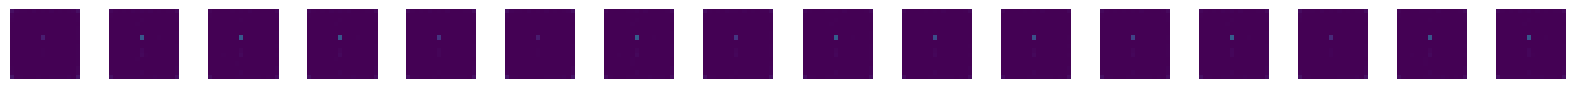

[Epoch 2/300] [D loss: 0.8833] [G loss: 0.0585] [Validity_loss: 0.0547] 
 [Stat_loss: 0.0005] [NNZ_loss: 0.0033]
Sample feature coding: [1.         0.7336914  0.08516806 0.9276066  0.354127   0.00940941
 0.05157713 0.00353776 0.0275337 ]


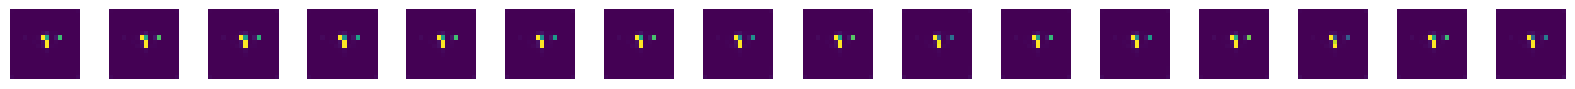

[Epoch 3/300] [D loss: 0.6984] [G loss: 0.0681] [Validity_loss: 0.0671] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0009]
Sample feature coding: [ 0.         -0.29791307  0.09360402  0.17756473  0.8539867   0.00994233
  0.07613956  0.00345291  0.03033068]


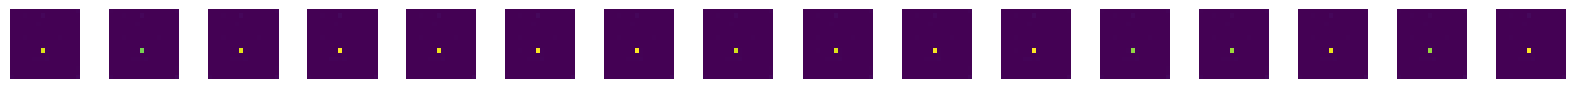

[Epoch 4/300] [D loss: 0.6908] [G loss: 0.0679] [Validity_loss: 0.0669] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0010]
Sample feature coding: [ 1.         -1.6428981   0.93959755  0.49956778  0.3599176   0.00927515
  0.06405336  0.00376047  0.03101322]


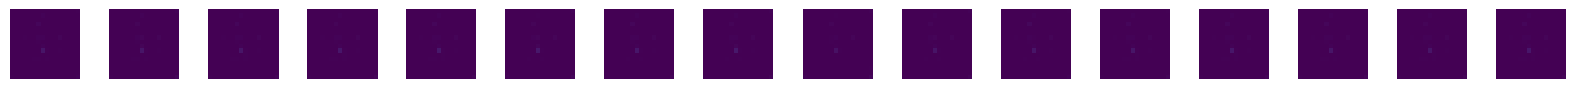

[Epoch 5/300] [D loss: 0.7793] [G loss: 0.0544] [Validity_loss: 0.0533] 
 [Stat_loss: 0.0000] [NNZ_loss: 0.0010]
Sample feature coding: [ 0.         -0.41019896  0.0726005   0.49209863  0.55342126  0.00594614
  0.10273497  0.00389457  0.0281642 ]


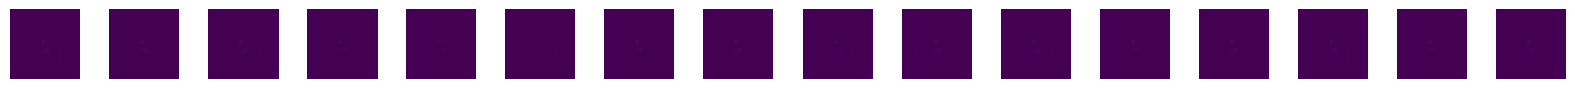

[Epoch 6/300] [D loss: 0.6980] [G loss: 0.0706] [Validity_loss: 0.0695] 
 [Stat_loss: 0.0003] [NNZ_loss: 0.0008]
Sample feature coding: [ 0.         -1.6529684   0.14421915  0.97014654  0.74855757  0.00946455
  0.05012824  0.00341037  0.01861394]


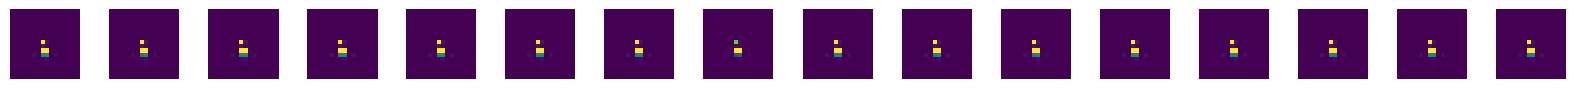

In [ ]:
tracked_fake_dR_mean = []
tracked_fake_dR_std = []
tracked_fake_pixel_mean = []
tracked_fake_pixel_std = []

tracked_real_dR_mean = []
tracked_real_dR_std = []
tracked_real_pixel_mean = []
tracked_real_pixel_std = []

latent_dim = 256
lr = 10e-4
n_epochs = 300
num = 4

generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.9, 0.999))

g_losses = []
d_losses = []

# Image shape: (16, 16)
H, W = (16, 16)
center_x, center_y = (W - 1) / 2, (H - 1) / 2

# Coordinate grid
x_coords, y_coords = torch.meshgrid(
    torch.arange(W, dtype=torch.float32),
    torch.arange(H, dtype=torch.float32),
    indexing='ij')

# Distance from center
dists = (torch.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)).cuda()
dists = dists.unsqueeze(0)  # [1, 16, 16]

for epoch in range(n_epochs):
    for i, (real_image, real_features, flipped_image, flipped_features) in enumerate(dataloader):
        
        # All real data are normalized in the dataloader
        real_feat = real_features.cuda()
        real_flipped_feat = flipped_features.cuda()
        real_img = real_image.unsqueeze(1).cuda()
        real_flipped_img = flipped_image.unsqueeze(1).cuda()

        # print(f"Real: {real_img.shape}")

        # Codings should be label, eta, pT, mass that get passed directly to the discriminator
        # Other values are pure noise and get passed to the generator, then those outputs passed to the discriminator

        # Discriminator training
        if i % 3 == 0:
            optimizer_D.zero_grad()
            discriminator.train()
            # Generate fake samples
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)
            # print(f"Fake: {fake_img.shape}")

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            real_disc_codings = real_feat[:,:num]
            real_flipped_disc_codings = real_flipped_feat[:,:num]
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]

            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            fake_pred = discriminator(fake_img, fake_disc_codings)
            fake_flipped_pred = discriminator(fake_flipped_img, fake_flipped_disc_codings)

            preds = (torch.cat([real_pred, real_flipped_pred, fake_pred, fake_flipped_pred], dim=0)).squeeze(1)


            # real_labels = torch.empty_like(real_pred).uniform_(0.7, 1.2)
            # fake_labels = torch.empty_like(fake_pred).uniform_(0.0, 0.3)
            # labels = (torch.cat([real_labels, fake_labels], dim=0)).cuda()

            ones = torch.ones(2*len(fake_pred))
            zeros = torch.zeros(2*len(real_pred))
            labels = (torch.cat([ones, zeros], dim=0)).cuda()

            # Discriminator loss is just its ability to distinguish
            d_loss = torch.nn.BCELoss()(preds, labels)

            d_loss.backward()
            optimizer_D.step()

        # Generator Training
        if i % 1 == 0:
            optimizer_G.zero_grad()
            # generator.train()
            
            # Generate fake data
            # Should be very easy to modify which values are passed as codings
            z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                                  sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                                  dim=1).cuda()
            # z_noise = torch.randn(batch_size, 5, ).cuda()
            # z_codings = torch.cat([z_codings, z_noise], dim=1)

            # Discriminator gets z_codings + generated_features
            fake_img = generator(z_codings)

            # Generate eta-flipped data
            flipped_z_codings = z_codings.clone()
            flipped_z_codings[:, 1] *= -1
            
            fake_flipped_img = generator(flipped_z_codings)

            # Get predictions and labels
            fake_disc_codings = z_codings[:,:num]
            fake_flipped_disc_codings = flipped_z_codings[:,:num]
            
            # Fooled discriminator loss
            d_out = discriminator(fake_img, fake_disc_codings)
            d_out_flip = discriminator(fake_flipped_img, fake_flipped_disc_codings)
            real_pred = discriminator(real_img, real_disc_codings)
            real_flipped_pred = discriminator(real_flipped_img, real_flipped_disc_codings)
            
            target = torch.ones_like(d_out)
            bce = nn.BCELoss()
            validity_loss = bce(d_out, target) + bce(d_out_flip, target)
            
            # ----- Fake ΔR Calculation -----
            # Original
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_img.squeeze(1)

            dR = (weights * dists)

            fake_dR_mean = dR.mean(dim = (1,2))
            fake_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            fake_pixel_mean = weights.mean(dim = (1,2))
            fake_pixel_std = weights.std(dim = (1,2))
            
            # Flipped
            # Weighted: pixel * distance / sum(pixel)
            weights = fake_flipped_img.squeeze(1)
            dR = (weights * dists)

            flipped_dR_mean = dR.mean(dim = (1,2))
            flipped_dR_std = dR.std(dim = (1,2))
            
            # Pixel stats
            flipped_pixel_mean = weights.squeeze(1).mean(dim = (1,2))
            flipped_pixel_std = weights.squeeze(1).std(dim = (1,2))

            real_dR_mean = z_codings[:,5]
            real_dR_std = z_codings[:,6]
            real_pixel_mean = z_codings[:,7]
            real_pixel_std = z_codings[:,8]


            # Statistical MSE loss
            # dR_mean_loss = (torch.nn.MSELoss()(fake_dR_mean, real_dR_mean) + torch.nn.MSELoss()(flipped_dR_mean, real_dR_mean))
            # dR_std_loss = (torch.nn.MSELoss()(fake_dR_std, real_dR_std) + torch.nn.MSELoss()(flipped_dR_std, real_dR_std))
            # pixel_mean_loss = (torch.nn.MSELoss()(fake_pixel_mean, real_pixel_mean) + torch.nn.MSELoss()(flipped_pixel_mean, real_pixel_mean))
            # pixel_std_loss = (torch.nn.MSELoss()(fake_pixel_std, real_pixel_std) + torch.nn.MSELoss()(flipped_pixel_std, real_pixel_std))
            
            # stat_loss = dR_mean_loss + dR_std_loss + 3*pixel_mean_loss + 2*pixel_std_loss

            # print(dR_mean_loss)
            # print(dR_std_loss)
            # print(3*pixel_mean_loss)
            # print(2*pixel_std_loss)

            # Statistical KL Divergence loss
            kl_total = 0
            kl_total += kde_kl_divergence_torch(real_dR_mean, fake_dR_mean) / .001
            kl_total += kde_kl_divergence_torch(real_dR_std, fake_dR_std) / .03
            kl_total += kde_kl_divergence_torch(real_pixel_mean, fake_pixel_mean) / .0001
            kl_total += kde_kl_divergence_torch(real_pixel_std, fake_pixel_std) / .01

            stat_loss = kl_total

            # Number non-zero loss
            fake_nnz = soft_count_nonzero(fake_img, threshold=3e-3, sharpness=10000.0)
            real_nnz = soft_count_nonzero(real_img, threshold=3e-3, sharpness=10000.0)
            nnz_loss = torch.nn.MSELoss()(fake_nnz, real_nnz)

            
            # Total generator loss is the average of the discriminator's predictions of the original and flipped data
            # + the difference between input and output dR and pixel statistics

            alpha = .05
            beta = .00001
            chi = .0001

            g_loss = (alpha*validity_loss + beta*nnz_loss + chi*stat_loss)

            g_loss.backward()
            optimizer_G.step()

            if n_epochs - epoch <= 10:
                # Track fake stats
                tracked_fake_dR_mean.append(fake_dR_mean.detach().cpu())
                tracked_fake_dR_std.append(fake_dR_std.detach().cpu())
                tracked_fake_pixel_mean.append(fake_pixel_mean.detach().cpu())
                tracked_fake_pixel_std.append(fake_pixel_std.detach().cpu())
                
                # Track real stats from z_codings
                tracked_real_dR_mean.append(z_codings[:,5].detach().cpu())
                tracked_real_dR_std.append(z_codings[:,6].detach().cpu())
                tracked_real_pixel_mean.append(z_codings[:,7].detach().cpu())
                tracked_real_pixel_std.append(z_codings[:,8].detach().cpu())

    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())

    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_losses[epoch]:.4f}] [G loss: {g_losses[epoch]:.4f}] [Validity_loss: {alpha*validity_loss:.4f}] \n [Stat_loss: {chi*stat_loss:.4f}] [NNZ_loss: {beta*nnz_loss:.4f}]") 

    z_img = torch.randn(batch_size, 256, 1, 1).cuda()

    # Should be very easy to modify which values are passed as codings
    z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                          sample_fit_noise(kdes, num_samples=batch_size)],
                          dim=1).cuda()
    # z_noise = torch.randn(batch_size, 5, ).cuda()
    # z_feat1 = torch.cat([z_codings, z_noise], dim=1)
    z_feat = torch.cat([z_codings], dim=1)

    fake_images = generator(z_feat)
    fake_feat = z_codings
    fake_images.detach().cpu()
    fake_feat.detach().cpu()
    # real_images = next(iter(dataloader))[0][:1000].cpu()

    # output_image = fake_images[:16]  # Save 16 generated samples
    # output_image = (output_image + 1) / 2.0  # Scale to [0, 1]
    # grid = (torchvision.utils.make_grid(output_image, nrow=4, normalize=True)).cpu()
    # np_img = grid.permute(1, 2, 0).numpy()
    # plt.imsave(f'classical_Jet_image_epoch_{epoch}.png', np_img)
    plot_generated_samples(generator, kdes, batch_size=16, latent_dim=256)

plot_metrics(g_losses, d_losses)

# Flatten all batches
fake_dR_mean_vals = torch.cat(tracked_fake_dR_mean).numpy() / batch_size
fake_dR_std_vals = torch.cat(tracked_fake_dR_std).numpy() / batch_size
fake_pixel_mean_vals = torch.cat(tracked_fake_pixel_mean).numpy() / batch_size
fake_pixel_std_vals = torch.cat(tracked_fake_pixel_std).numpy() / batch_size

real_dR_mean_vals = torch.cat(tracked_real_dR_mean).numpy() / batch_size
real_dR_std_vals = torch.cat(tracked_real_dR_std).numpy() / batch_size
real_pixel_mean_vals = torch.cat(tracked_real_pixel_mean).numpy() / batch_size
real_pixel_std_vals = torch.cat(tracked_real_pixel_std).numpy() / batch_size

fig, axs = plt.subplots(1, 4, figsize=(24, 6))  # 4 stats

stat_titles = ['ΔR Mean', 'ΔR Std', 'Pixel Mean', 'Pixel Std']
real_stats = [real_dR_mean_vals, real_dR_std_vals, real_pixel_mean_vals, real_pixel_std_vals]
fake_stats = [fake_dR_mean_vals, fake_dR_std_vals, fake_pixel_mean_vals, fake_pixel_std_vals]

for row in range(4):
    ax = axs[row]

    real_vals = real_stats[row]
    fake_vals = fake_stats[row]

    # Compute limits
    lower = min(np.percentile(real_vals, 1), np.percentile(fake_vals, 1))
    upper = max(np.percentile(real_vals, 99), np.percentile(fake_vals, 99))

    # Truncate values
    real_vals_trunc = real_vals[(real_vals >= lower) & (real_vals <= upper)]
    fake_vals_trunc = fake_vals[(fake_vals >= lower) & (fake_vals <= upper)]

    # Plot
    ax.hist(real_vals_trunc, bins=1000, alpha=0.6, label='Real',
            edgecolor='black', density=True, histtype='stepfilled')
    ax.hist(fake_vals_trunc, bins=1000, alpha=0.6, label='Fake',
            edgecolor='black', density=True, histtype='stepfilled')

    ax.set_xlim(lower, upper)
    ax.set_title(f"{stat_titles[row]}")
    ax.legend()

plt.tight_layout()
plt.suptitle("Real vs Fake Distributions by Statistic", fontsize=16, y=1.02)
plt.show()

![image.png](attachment:7aee3b98-579c-4bcb-9682-eb417b7e3a7a.png)

In [ ]:
n_rows, n_cols = 4, 16
n_images = n_rows * n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows * 1.5))

vmin = dataset.images[:n_images].min()
vmax = dataset.images[:n_images].max()

# Show images and keep the first imshow object for colorbar
im = None
for i in range(n_images):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(dataset.images[i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.axis('off')

# Add a single colorbar on the right of the grid
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [ ]:
def test_generated_samples(generator, kdes,  batch_size=4, latent_dim=256, codings = None):
    generator.eval()  # Set to eval mode to disable dropout/batchnorm updates

    # Latent vectors
    z_img = torch.randn(batch_size, latent_dim, 1, 1).cuda()
    # Should be very easy to modify which values are passed as codings
    z_codings = torch.cat([torch.randint(0, 2, (batch_size, 1)), 
                          sample_fit_noise(kdes, num_samples=batch_size)[:,:]],
                          dim=1).cuda()
    # z_noise = torch.randn(batch_size, 5, ).cuda()
    # z_feat = torch.cat([z_codings, z_noise], dim=1)
    z_feat = z_codings

    with torch.no_grad():
        gen_samples = generator(z_feat)

    gen_samples = gen_samples.cpu()
    
    print("Sample feature coding:", z_codings[1].cpu().numpy())

    fig, axes = plt.subplots(1, min(batch_size, 16), figsize=(min(batch_size, 16), 1))
    for i in range(min(batch_size, 16)):
        axes[i].imshow(gen_samples[i, 0].numpy(), cmap= 'viridis')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()
    
    generator.train()  # Restore training mode

In [ ]:
test_generated_samples(generator, kdes, batch_size=16, latent_dim=256, codings = [0., 1.1214281, 0.7953802, 0.9241728,  0.69733775, 0.0033828, 0.01578446, 0.00170709, 0.02212167])
n=16

pred1 = discriminator(dataset.images[:n].unsqueeze(1).cuda(), dataset.features[:n,:4].cuda())
print(pred1)
new_dataset = dataset.features[:n,:4].clone()
new_dataset[:n, 0] *= (-2**(new_dataset[:n, 0])+2)

pred2 = discriminator(dataset.images[:n].unsqueeze(1).cuda(), new_dataset[:n,:4].cuda())
print(pred2)

print((pred1/pred2 - 1)*100)